In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 증시 예측
- 데이터 유효성, 누락 검사
- 분포, 상관관계 분석
- 전처리 : X(이동 평균(5일?), 하루 전?), Y(다음날 종가? 거래량?) 분리, 정규화
- LinearRegression 점수 측정, tensorflow 뉴럴 네트워크로 점수 측정
- 그래프로 시각화 (역 정규화) 

In [3]:
삼성 = '005930'
삼천리자전거 = '024950'
url_base = 'https://finance.naver.com/item/sise_day.nhn?code='
url = url_base + 삼성 +'&page='
page_list = []
max_page = 31 
for page in range(1, max_page):
    tables = pd.read_html(url+str(page))
    page_list.append(tables[0]) # 네이버는 첫번쨰 테이블[0]이 증시데이터 입니다.
len(page_list)

30

In [4]:
df = pd.concat(page_list, axis=0)
df = df.dropna()
df = df.set_index('날짜').drop(columns='전일비')
df = df.iloc[::-1] # 행을 반대로 뒤집기 

In [39]:
df.head()

,종가,시가,고가,저가,거래량,전일비
날짜,,,,,,
2018.06.26,47000.0,45900.0,47300.0,45900.0,11223166.0,-1100.0
2018.06.27,47950.0,47450.0,48500.0,47000.0,15274752.0,-500.0
2018.06.28,46800.0,46850.0,47150.0,46600.0,12784800.0,50.0
2018.06.29,46650.0,46250.0,47150.0,46200.0,14099635.0,-400.0
2018.07.02,45550.0,46500.0,47150.0,45500.0,13112253.0,950.0


In [5]:
df.isna().sum().sum()

0

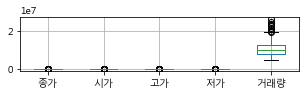

In [6]:
df.boxplot(figsize=(5,1))

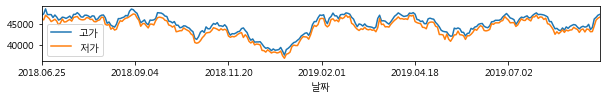

In [7]:
df[['고가', '저가']].plot(figsize=(10,1))

In [8]:
df.corr()

,종가,시가,고가,저가,거래량
종가,1.000000,0.970839,0.988026,0.987955,-0.270227
시가,0.970839,1.000000,0.986696,0.988068,-0.259498
고가,0.988026,0.986696,1.000000,0.988656,-0.227787
저가,0.987955,0.988068,0.988656,1.000000,-0.297126
거래량,-0.270227,-0.259498,-0.227787,-0.297126,1.000000


In [9]:
x = df.iloc[:-1] # 전날
y = df.iloc[1:]['종가'] # 다음날

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y)

0.9114939486222042

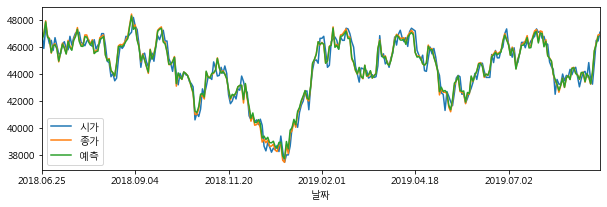

In [11]:
df[['시가', '종가']].plot(figsize=(10, 3))
plt.plot(model.predict(x), label='예측')
plt.legend()

전일비를 추가하자

In [12]:
#전일비 = 다음날 ? - 전날 ?
전일비 = df.iloc[1:]['시가']  - df.iloc[:-1]['종가'] 
df['전일비'] = 전일비
df = df.dropna()
#전일비

이동평균을 넣어보자

In [13]:
df_rol = df.rolling(window=5).mean()

In [14]:
df_rol.columns = ['종가_rol', '시가_rol', '고가_rol', '저가_rol', '거래량_rol','전일비_rol'] 

In [15]:
df_con = pd.concat((df, df_rol), axis=1).dropna()
df_con.head(1)

,종가,시가,고가,저가,거래량,전일비,종가_rol,시가_rol,고가_rol,저가_rol,거래량_rol,전일비_rol
날짜,,,,,,,,,,,,
2018.07.02,45550.0,46500.0,47150.0,45500.0,13112253.0,950.0,46790.0,46590.0,47450.0,46240.0,13298921.2,-200.0


In [16]:
x = df_con.iloc[:-1] # 전날
y = df_con.iloc[1:]['종가'] # 다음날

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y) #0.935 > 0.936

0.9128123959335408

In [18]:
import tensorflow as tf
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32).reshape([-1, 1])
x.shape, y.shape, np.min(y), np.max(y)

((293, 12), (293, 1), 37450.0, 48450.0)

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
scaler_x = MinMaxScaler().fit(x)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(x)
yn = scaler_y.transform(y)
np.min(xn), np.max(xn), np.min(yn), np.max(yn)

(0.0, 1.0, 0.0, 1.0)

In [ ]:
w1 = tf.Variable(tf.random_normal(shape=[12,20]))
b1 = tf.Variable(tf.random_normal(shape=[20]))
w2 = tf.Variable(tf.random_normal(shape=[20,1]))
b2 = tf.Variable(tf.random_normal(shape=[1]))
h1 = tf.sigmoid(tf.matmul(xn, w1) + b1)
out = tf.matmul(h1, w2) + b2
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.9).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [37]:
import tensorflow.contrib.slim as slim 
h1 = slim.fully_connected(xn, 10)#간단하게 행렬 곱셈을 사용
out = slim.fully_connected(h1, 1)
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [38]:
for i in range(10000):
    _, c = sess.run([train, cost])    
    if i%1000 == 0: print(i, c, r2_score(yn, sess.run(out)))
print(i, c, r2_score(yn, sess.run(out)))

0 0.10180028 -0.7514598939784678
1000 0.00369661 0.9095763049365427
2000 0.0036513011 0.9106836679891043
3000 0.0036251561 0.9113230464863323
4000 0.0036058275 0.9117956496005256
5000 0.003590518 0.9121698245806481
6000 0.0035787248 0.9124584313596991
7000 0.0035692551 0.9126899020222012
8000 0.0035613438 0.912883466373454
9000 0.0035545821 0.9130488493181091
9999 0.003548721 0.9131921712125963


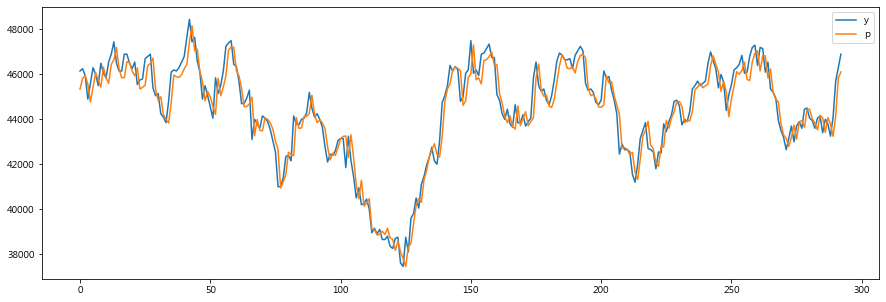

In [36]:
plt.figure(figsize=(15,5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(out)), label='p')
plt.legend()

지금까지는 데이터에 시간축이 없었습니다
예를 들어 100일치 데이터에서 전날 > 다음날 예측
X 99, Y 99 개 만들 수 있습니다

X 는 5일치 데이터입니다 
Y 는 다음날 하루 데이터입니다 
X, Y 95 셋트 만들 수 있습니다 

In [44]:
df_con.shape, len(df_con) - 5 

((294, 12), 289)

In [111]:
T = 5
# X (289, 5, 12), y (289)
x_list = []
y_list = []
for i in range(len(df_con) - T):
    x = df_con.iloc[i : i+T]
    y = df_con.iloc[i+T]['종가']
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(289, 289)

In [61]:
X = np.stack(x_list, 0).astype(np.float32)
y = np.stack(y_list, 0).astype(np.float32).reshape([-1, 1])
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (289, 5, 12), (289, 1), dtype('float32'), dtype('float32'))

In [81]:
from sklearn.preprocessing import MinMaxScaler
X_2d = X.reshape([-1, 12]) # 3d > 2d
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y)
xn = xn.reshape(X.shape) # 2d > 3d
xn.shape, np.min(xn), np.max(xn), np.min(yn), np.max(yn)

((289, 5, 12), 0.0, 1.0, 0.0, 1.0)

In [89]:
xn.shape, yn.shape

((289, 5, 12), (289, 1))

In [117]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()

cell = tf.nn.rnn_cell.GRUCell(100) # LSTM보다 약간 빠르고 성능은 약간 떨어진다
# CRNN convolution / Reccurent / FC 
net = slim.conv1d(xn, num_outputs=10, kernel_size=3)
outputs, last_state = tf.nn.dynamic_rnn(cell, net, dtype=tf.float32)
h = slim.fully_connected(last_state, 1)# W, b 가 자동으로 생성되서 행렬곱셈합니다
cost = tf.reduce_mean((yn - h)**2)
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [118]:
for i in range(10000):
    _, c = sess.run([train, cost])    
    if i%1000 == 0: print(i, c, r2_score(yn, sess.run(h)))
print(i, c, r2_score(yn, sess.run(h)))

0 0.43596938 -8.709478229873278
1000 0.008526487 0.7929927878323364
2000 0.0074150315 0.819964320132641
3000 0.00676438 0.8357570081643635
4000 0.0062920502 0.847223826770945
5000 0.005888967 0.8570108349864672
6000 0.005557734 0.8650515437668537
7000 0.005285491 0.8716614183736575
8000 0.005049488 0.8773912517787578
9000 0.0048460774 0.8823298427816484
9999 0.0046677683 0.8866590702228094


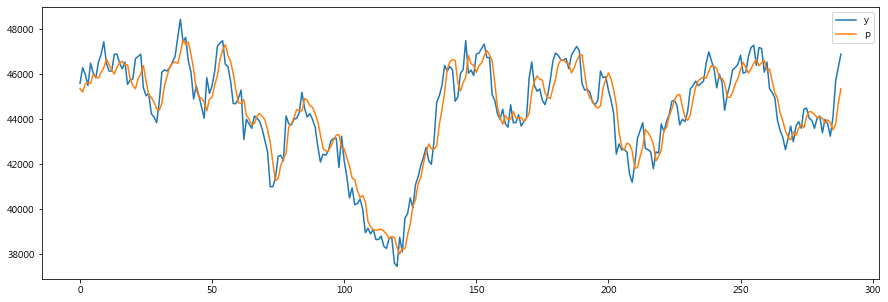

In [119]:
plt.figure(figsize=(15,5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(h)), label='p')
plt.legend()